In [163]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [164]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix, n_component
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc, LOO_validation
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split
from gmr import GMM
from bayesian.subsample import get_subsample
from visualization.visualization import get_probability

In [165]:
geo = pd.read_csv('../data/daks_processed_with_rf.csv')
geo.head(10)
columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Depositional environment', 'Gross','Netpay','Porosity','Permeability', 'Depth', 'Oil density', 'Oil recovery factor']
geo = geo[columns]
geo.dropna(inplace=True)
geo.reset_index(inplace=True, drop=True)

In [166]:
train, test = train_test_split(geo, test_size=0.25)
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

In [167]:
train.to_csv('train_geo.csv', index=False)
test.to_csv('test_geo.csv', index=False)

In [168]:
geo_types = get_nodes_type(geo)
geo_types

{'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Depositional environment': 'disc',
 'Gross': 'cont',
 'Netpay': 'cont',
 'Porosity': 'cont',
 'Permeability': 'cont',
 'Depth': 'cont',
 'Oil density': 'cont',
 'Oil recovery factor': 'cont'}

In [169]:
geo_signs = get_nodes_sign(geo)
geo_signs

{'Gross': 'pos',
 'Netpay': 'pos',
 'Porosity': 'pos',
 'Permeability': 'pos',
 'Depth': 'pos',
 'Oil density': 'pos',
 'Oil recovery factor': 'pos'}

In [170]:
colums_for_code = []
columns_for_disc = []
for c in columns:
    if geo_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)

In [171]:
geo_coded, label_coder = code_categories(geo, 'label', colums_for_code)
geo_discrete, coder = discretization(geo_coded, 'equal_frequency', columns_for_disc, bins=5)
#geo_only_discrete, discrete_coder = discretization(geo, 'equal_frequency', columns_for_disc)

In [172]:
bn_full = structure_learning(geo_discrete, 'HC', geo_types, 'K2')

  0%|          | 20/1000000 [00:17<241:04:41,  1.15it/s]


In [173]:
draw_BN(bn_full, geo_types, 'all_net')

In [174]:
params = parameter_learning(geo, geo_types, bn_full, 'simple')
save_structure(bn_full, 'all_net')
skel = read_structure('all_net')
save_params(params, 'all_net_param')
params = read_params('all_net_param')
all_bn = HyBayesianNetwork(skel, params)

SyntaxError: invalid syntax (<ipython-input-174-2bef9542ec94>, line 1)

In [149]:
acc, rmse, real, pred = calculate_acc(all_bn, test, ['Oil recovery factor'], 'simple', normed=False)

In [150]:
rmse

{'Oil recovery factor': 0.14}

In [175]:
target_unit = {'Lithology':'SANDSTONE', 'Period': 'JURASSIC', 'Structural setting': 'WRENCH', 'Gross': 160, 'Netpay': 157, 'Permeability': 221, 'Porosity': 17, 'Depth': 1566, 'Oil density': 815.5}

In [180]:
sample = get_subsample(target_unit, geo, 'cosine', ['Lithology', 'Period', 'Structural setting', 'Gross', 'Netpay', 'Permeability', 'Porosity', 'Depth'], 40)
sample.reset_index(inplace=True, drop=True)

In [181]:
sample_coded, label_coder = code_categories(sample, 'label', colums_for_code)
sample_discrete, coder = discretization(sample_coded, 'equal_frequency', columns_for_disc)

In [182]:
bn_full = structure_learning(sample_discrete, 'HC', geo_types, 'K2')

  0%|          | 15/1000000 [00:01<33:36:38,  8.26it/s]


In [183]:
draw_BN(bn_full, geo_types, 'sample_net')

In [122]:
params = parameter_learning(sample, geo_types, bn_full, 'simple')
save_structure(bn_full, 'all_net')
skel = read_structure('all_net')
save_params(params, 'all_net_param')
params = read_params('all_net_param')
all_bn = HyBayesianNetwork(skel, params)

In [123]:
sample_rv = generate_synthetics(all_bn, geo_signs, 'simple', 1000)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Oil recovery factor', ylabel='Density'>

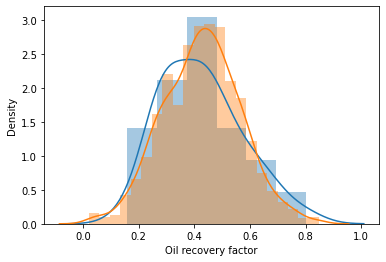

In [124]:
sns.distplot(sample['Oil recovery factor'])
sns.distplot(sample_rv['Oil recovery factor'])

In [125]:
sample_rv['Oil recovery factor'].mean()

0.4271710651044474

In [115]:
geo_sample = geo.loc[(geo['Oil recovery factor'] > 0.2) & (geo['Oil recovery factor'] < 0.3)]

In [117]:
geo_sample['Netpay'].mean()

49.53703703703703